In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch as torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models

In [2]:
import pickle as pkl
from tqdm.notebook import tqdm

In [3]:
DEVICE = torch.device("cuda:0")
DIM = 128
IMAGE_SIZE = 112
dtype = torch.cuda.FloatTensor

In [4]:
torch.cuda.is_available()

True

In [5]:
data_ = pkl.load(open('Data_siamese.pickle', 'rb'))

In [6]:
data_.shape

(6317, 20, 112, 112, 3)

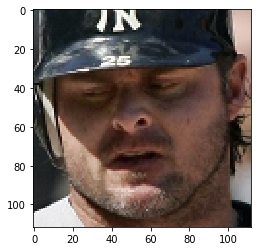

In [40]:
plt.imshow(data_[141, 0])
plt.savefig('exz_1.jpg')
plt.show()

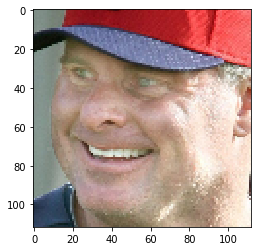

In [41]:
plt.imshow(data_[141, 13])
plt.savefig('exz_2.jpg')
plt.show()

In [7]:
data = data_[4001:, :, :, :, :]

In [8]:
model = models.mobilenet_v2(width_mult=1, pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))

In [9]:
class Bottleneck(nn.Module):
    def __init__(self, model, in_dim=1280, out_dim=DIM, spartial=(IMAGE_SIZE+31) // 32):
        super().__init__()
        self.model = model
        self.depthwise = nn.Conv2d(in_dim, in_dim, spartial, bias=False, groups=in_dim)
        self.linear = nn.Linear(in_dim, out_dim)
        
    def forward(self, x):
        x = self.model(x)
        x = self.depthwise(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [10]:
model = Bottleneck(model)
model = model.to(DEVICE)

In [11]:
class Probcalc(nn.Module):
    def __init__(self, in_dim = 128):
        super().__init__()
        self.layer = nn.Linear(in_dim, 1)
    
    def forward(self, x):
        x = self.layer(x)
        x = torch.sigmoid(x)
        return x

In [12]:
calcprob = Probcalc().to(DEVICE)

In [13]:
model.load_state_dict(torch.load("model.state"))
model.eval()
calcprob.load_state_dict(torch.load("dist2prob.state"))
calcprob.eval()

Probcalc(
  (layer): Linear(in_features=128, out_features=1, bias=True)
)

In [14]:
rng = np.random.default_rng()

In [15]:
import cv2
from PIL import Image

In [16]:
def dist(x1, x2):
    return torch.abs(x1 - x2)

In [17]:
EPOCHS = 60
STEP_PER_EPOCH = 2000
BATCH = 64

In [18]:
def gen_pair(true_pair = True):
    batch_data_1 = torch.zeros(BATCH, 3, 112, 112).byte()
    batch_data_2 = torch.zeros(BATCH, 3, 112, 112).byte()
    if true_pair:
        good = rng.choice(2300, size = BATCH, replace=True)
        for i in range(BATCH):
            ind = rng.choice(20, size=2, replace=True)
            batch_data_1[i] = torch.tensor((data[good[i], ind[0]] - 255 / 2) /  (255 / 2)).transpose(0, 2)
            batch_data_2[i] = torch.tensor((data[good[i], ind[1]] - 255 / 2) /  (255 / 2)).transpose(0, 2)
    else:
        for i in range(BATCH):
            ind1 = rng.choice(2300, size=2, replace=False)
            ind = rng.choice(20, size=2, replace=True)
            batch_data_1[i] = torch.tensor((data[ind1[0], ind[0]] - 255 / 2) /  (255 / 2)).transpose(0, 2)
            batch_data_2[i] = torch.tensor((data[ind1[1], ind[1]] - 255 / 2) /  (255 / 2)).transpose(0, 2)   
        
    return batch_data_1, batch_data_2

In [19]:
from torchvision import transforms

In [26]:
cnt = 0.0
for s in tqdm(range(2000)):  
        X1, X2 = gen_pair()
        X1 = X1.to(DEVICE).float()
        X2 = X2.to(DEVICE).float()
        diff = dist(model(X1), model(X2))
        prob = calcprob(diff)
        cnt += (prob >= 0.5).sum().item()
        

In [27]:
print("Accurancy on true pairs ", cnt / (2000 * BATCH))

Accurancy on true pairs  0.630828125


In [28]:
cnt1 = 0.0
for s in tqdm(range(2000)):  
        X1, X2 = gen_pair(true_pair = False)
        X1 = X1.to(DEVICE).float()
        X2 = X2.to(DEVICE).float()
        diff = dist(model(X1), model(X2))
        prob = calcprob(diff)
        cnt1 += (prob < 0.5).sum().item()
        

In [29]:
print("Accurancy on false pairs ", cnt1 / (2000 * BATCH))

Accurancy on false pairs  0.5569453125
